In [1]:
from google.colab import drive 
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Rating-Prediction-main

/content/drive/MyDrive/Rating-Prediction-main


In [4]:
!pip install tensorflow==2.1.0

     |████████████████████████████████| 421.8MB 36kB/s 
     |████████████████████████████████| 3.9MB 28.9MB/s 
     |████████████████████████████████| 51kB 5.3MB/s 
     |████████████████████████████████| 450kB 41.9MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=f65d54904a7a63f2d1a1706d802d125e6fa194d5f52b84d0ffce785a58723ce9
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tens

In [5]:
!pip install keras==2.3.1

     |████████████████████████████████| 378kB 5.1MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [6]:
from collections import Counter
from itertools import combinations
from math import sqrt
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" #comment out this line if you want to use gpu
import random
from keras.layers import Concatenate, Dense, Dot, Dropout, Embedding, Input, Reshape
from keras.models import Model
from keras.callbacks import Callback, ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import tensorflow
import pandas as pd
import ast
import math

Using TensorFlow backend.


### Set random seed

In [7]:
import random
random.seed(2021)
np.random.seed(2021)
# tf > 2.0
tensorflow.random.set_seed(2021)
#tf < 2.0
#tf.set_random_seed(2021)

In [8]:
'''
params:
    -pred: an array containing all predicted ratings
    -actual: an array containing all ground truth ratings
    
return:
    a scalar whose value is the rmse
'''
def rmse(pred, actual):
    # Ignore ratings with value zero.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return sqrt(mean_squared_error(pred, actual))

# Implement Wide and Deep Learning (WDL) Model

In [56]:
'''
params:
    -len_continuous: number of continuous features
    -deep_vocab_lens: an array of integers where deep_vocab_lens[i] represents the number of unique values of (i+1)-th deep 
        categorical feature
    -len_wide: number of wide features
    -embed_size: dimension of the embedding vectors of deep categorical features
    
return:
    a keras Model object for the constructed wdl model 
'''


def build_wdl_model(len_continuous, deep_vocab_lens, len_wide, embed_size):
    # A list containing all input layers
    input_list = []
    
    # Input layer for continuous features
    continuous_input = Input(shape=(len_continuous,), dtype='float32', name='continuous_input')
    input_list.append(continuous_input)
    
    
    # Get embeddings for all deep categorical features
    emb_list = []
    for vocab_size in deep_vocab_lens:
        _input = Input(shape=(1,), dtype='int32')
        input_list.append(_input)
        _emb = Embedding(output_dim=embed_size, input_dim=vocab_size, input_length=1)(_input)
        _emb = Reshape((embed_size,))(_emb)
        emb_list.append(_emb)
    
    
   
    # Create input layer for deep component by concatenating the embeddings and continuous features' input layer
    deep_input = Concatenate()(emb_list + [continuous_input])
    

    # Construct deep component
    dense_1 = Dense(256, activation='relu')(deep_input)
    dense_1_dp = Dropout(0.5)(dense_1)
    dense_2 = Dense(128, activation='relu')(dense_1_dp)
    dense_2_dp = Dropout(0.4)(dense_2)
    dense_3 = Dense(64, activation='relu')(dense_2_dp)
    dense_3_dp = Dropout(0.4)(dense_3)
    dense_3_dp = dense_3


    
    # Create input layer for wide component
    wide_input = Input(shape=(len_wide,), dtype='float32')
    input_list.append(wide_input)

    
    # Concatenate the outputs of deep and wide components and feed the 
    # concatenated vector into the finall fully connected layer
    fc_input = Concatenate()([dense_3_dp, wide_input])
    model_output = Dense(1)(fc_input)
    
    model = Model(inputs=input_list,
                  outputs=model_output)
    return model
    

# Utility functions to get the values of different types of features

### Continuous features

In [10]:
'''
params:
    -df: input dataframe
    -continuous_columns: column names of continuous features
    
return: 
    a numpy array where each row contains the values of continuous features in the corresponding row of the
    input dataframe
'''
def get_continuous_features(df, continuous_columns):
    continuous_features = df[continuous_columns].values
    return continuous_features

### Cross product transformation of categorical features

In [11]:
'''
params:
    -df: input dataframe
    -comb_p: number of elements in each combination (e.g., there are two elements in the combination {fried chicken, chicken and 
    waffle}, and three elements in the combination {fried chicken, chicken and waffle, chicken fried rice})
    -topk: number of mostly frequent combinations to retrieve
    -output_freq: whether to return the frequencies of retrieved combinations
    
return:
    1. output_freq = True: a list X where each element is a tuple containing a combinantion tuple and corresponding frequency, and the 
        elements are stored in the descending order of their frequencies
    2. output_freq = False: a list X where each element is a tuple containing a combinantion tuple, and the elements are stored in 
    the descending order of their frequencies
'''
def get_top_k_p_combinations(df, comb_p, topk, output_freq=False):
    # get all combinations with comb_p
    def get_category_combinations(categories_str, comb_p=2):
        categories = categories_str.split(', ')
        return list(combinations(categories, comb_p))
    # [('Lounges', 'Dance Clubs'), ('Lounges', 'Bars'), ('Lounges', 'Nightlife'), ('Dance Clubs', 'Bars'), ('Dance Clubs', 'Nightlife'), ('Bars', 'Nightlife')]
    all_categories_p_combos = df["item_categories"].apply(
        lambda x: get_category_combinations(x, comb_p)).values.tolist()
    # ('Lounges', 'Dance Clubs')
    # list of tuples that each index refer to one combination
    all_categories_p_combos = [tuple(t) for item in all_categories_p_combos for t in item]

    tmp = dict(Counter(all_categories_p_combos))
    sorted_categories_combinations = list(sorted(tmp.items(), key=lambda x: x[1], reverse=True))
    if output_freq:
        return sorted_categories_combinations[:topk]
    else:
        return [t[0] for t in sorted_categories_combinations[:topk]]

### Wide features

In [12]:
'''
params:
    -df: input dataframe
    -selected_categories_to_idx: a dictionary mapping item categories to corrresponding integral indices
    -top_combinations: a list containing retrieved mostly frequent combinantions of item categories
    
return:
    a numpy array where each row contains the categorical features' binary encodings and cross product
    transformations for the corresponding row of the input dataframe
'''

def get_wide_features(df, selected_categories_to_idx, top_combinations):
    def categories_to_binary_output(categories):
        binary_output = [0 for _ in range(len(selected_categories_to_idx))]
        for category in categories.split(', '):
            if category in selected_categories_to_idx:
                binary_output[selected_categories_to_idx[category]] = 1
            else:
                binary_output[0] = 1
        return binary_output
    def categories_cross_transformation(categories):
        current_category_set = set(categories.split(', '))
        corss_transform_output = [0 for _ in range(len(top_combinations))]
        for k, comb_k in enumerate(top_combinations):
            if len(current_category_set & comb_k) == len(comb_k):
                corss_transform_output[k] = 1
            else:
                corss_transform_output[k] = 0
        return corss_transform_output

    category_binary_features = np.array(df.item_categories.apply(
        lambda x: categories_to_binary_output(x)).values.tolist())
    print('category_binary_features shape:',category_binary_features.shape)
    category_corss_transform_features = np.array(df.item_categories.apply(
        lambda x: categories_cross_transformation(x)).values.tolist())
    print('category_cross_features shape:',category_corss_transform_features.shape)
    out = np.concatenate((category_binary_features, category_corss_transform_features), axis=1)
    print('wide features shape:',out.shape)
    return np.concatenate((category_binary_features, category_corss_transform_features), axis=1)


# Rating Prediction

### Load train, validation and test rating tables

In [13]:
def isnan(value):
    try:
        return math.isnan(float(value))
    except:
        return False

In [14]:
tr_df = pd.read_csv("data/train.csv")
val_df = pd.read_csv("data/valid.csv")
te_df = pd.read_csv("data/test.csv")

tr_ratings = tr_df.stars.values
val_ratings = val_df.stars.values



### Load content feautures tables of users and items

In [15]:
user_df = pd.read_csv("data/user.csv")
item_df = pd.read_csv("data/business.csv")

# Rename some columns of dfs and convert the indices of dfs into string type for easier reference in later stage 
user_df = user_df.rename(index=str, columns={t: 'user_' + t for t in user_df.columns if t != 'user_id'})
item_df = item_df.rename(index=str, columns={t: 'item_' + t for t in item_df.columns if t != 'business_id'})


In [17]:
for i,dict_str in enumerate(item_df["item_attributes"]):
    # check for nan
    # if(isnan(dict_str)):
    #     print(f'line {i+1} has nan index')
#         print('**'*20)
#         print(dict_str)
    else:
        dict_str = dict_str.replace('"','')
        temp_dict = ast.literal_eval(dict_str)  
        item_df["item_attributes"][i] = temp_dict

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


line 44 has nan index
line 177 has nan index
line 199 has nan index
line 335 has nan index
line 385 has nan index
line 401 has nan index
line 404 has nan index
line 488 has nan index
line 550 has nan index
line 624 has nan index
line 720 has nan index
line 770 has nan index
line 1065 has nan index
line 1112 has nan index
line 1130 has nan index
line 1134 has nan index
line 1191 has nan index
line 1384 has nan index
line 1413 has nan index
line 1506 has nan index
line 1510 has nan index
line 1775 has nan index
line 1883 has nan index
line 1885 has nan index
line 2024 has nan index
line 2349 has nan index
line 2375 has nan index
line 2415 has nan index
line 2429 has nan index
line 2476 has nan index
line 2506 has nan index
line 2601 has nan index
line 2802 has nan index
line 2823 has nan index
line 3232 has nan index
line 3269 has nan index
line 3356 has nan index
line 3378 has nan index
line 3549 has nan index
line 3714 has nan index
line 4086 has nan index
line 4155 has nan index
line 

### Associate each row in the rating tables with corresponding user's and item's content features through merging the rating tables and content features tables

In [18]:
# Save the original row indices of each rating table
tr_df["index"] = tr_df.index
val_df["index"]  = val_df.index
te_df["index"] = te_df.index

tr_df = pd.merge(pd.merge(tr_df, user_df, on='user_id'), item_df, on='business_id').sort_values(by=['index']).reset_index(drop=True)
val_df = pd.merge(pd.merge(val_df, user_df, on='user_id'), item_df, on='business_id').sort_values(by=['index']).reset_index(drop=True)
te_df = pd.merge(pd.merge(te_df, user_df, on='user_id'), item_df, on='business_id').sort_values(by=['index']).reset_index(drop=True)

### Prepare wide features

##### Prepare binary encoding for each selected category

In [36]:
# Collect the categories of all items 
all_categories = [category for category_list in item_df.item_categories.values for category in category_list.split(", ")]

# Sort all unique values of the item categories by their frequencies in descending order
category_sorted = sorted(Counter(all_categories).items(), key=lambda x: x[1], reverse=True)

# Select top 500 most frequent categories
selected_categories = [t[0] for t in category_sorted[:500]]

# Create a dictionary mapping each secleted category to a unique integral index
selected_categories_to_idx = dict(zip(selected_categories, range(1, len(selected_categories) + 1)))

# Map all categories unseen in the item df to index 0
selected_categories_to_idx['unk'] = 0

# Create a dictionary mapping each integral index to corresponding category
idx_to_selected_categories = {val: key for key, val in selected_categories_to_idx.items()}


In [82]:
#@title Here we plot the top 10 categories by its corresponding frequency


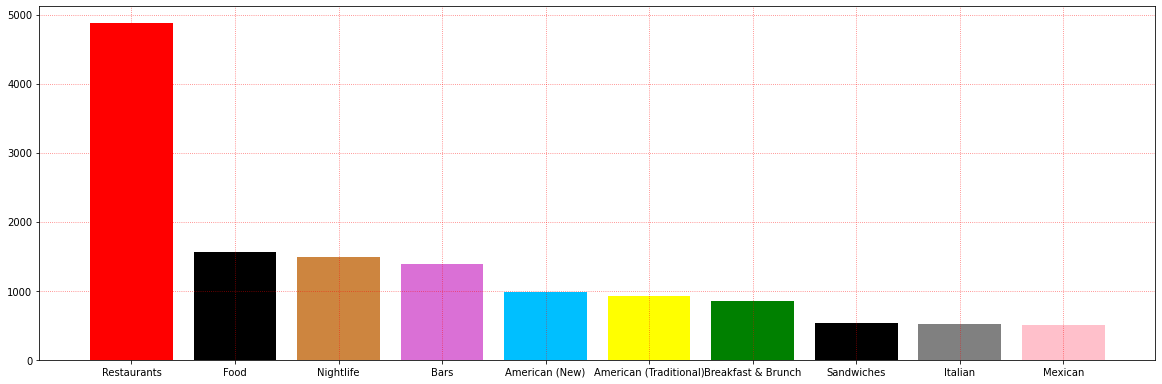

In [80]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 6.5))
x=[1,2,3,4,5,6,7,8,9,10]  
x_label=[]
y=[]  

for i in range(10):
  y.append(category_sorted[:20][i][1])
  x_label.append(category_sorted[:20][i][0])


color=['red','black','peru','orchid','deepskyblue','yellow','green','black','grey','pink']

plt.xticks(x, x_label)  
plt.bar(x, y,color=color)  

plt.grid(True,linestyle=':',color='r',alpha=0.6)
plt.show()